# Simple SNN by Brian2
シンプルにしたDiehl&CookモデルによるSTDPを用いた教師なし学習

In [1]:
import brian2 as b2
import numpy as np
from sklearn import datasets
np.random.seed(101)

In [2]:
# Load MNIST
mnist_X, mnist_y = datasets.fetch_openml('mnist_784', version=1, data_home="./mnist/", return_X_y=True)
x_all = mnist_X.astype(np.float32) / 255
y_all = mnist_y.astype(np.int32)
print(x_all.shape)
print(y_all.shape)

(70000, 784)
(70000,)


In [3]:
# parameter
num_examples = 100
n_input = x_all.shape[1]
n = n_e = n_i = 100
single_example_time =   0.35 * b2.second
resting_time = 0.15 * b2.second
runtime = num_examples * (single_example_time + resting_time)
input_intensity = 100 * b2.Hz # inputにおける最大のスパイク頻度

In [4]:
# Create Network
## Input layer
input_groups = {}
input_groups['X'] = b2.PoissonGroup(n_input, 0*b2.Hz)

## Excitory and Inhibitory Layer
neuron_groups = {}
v0 = -50 * b2.mV #静止膜電位
v_th = -40 * b2.mV #閾値電位
v_re = -60 * b2.mV #リセット電位
tau = 10 * b2.ms #膜時定数
ref = 2 * b2.ms # 不応期
eqs = '''
dv/dt = (v0-v)/tau : volt (unless refractory)
'''
neuron_groups['e'] = b2.NeuronGroup(n_e, eqs, threshold='v > v_th', reset='v = v_re', refractory=ref, method='euler')
neuron_groups['i'] = b2.NeuronGroup(n_i, eqs, threshold='v > v_th', reset='v = v_re', refractory=ref, method='euler')
neuron_groups['e'].v = neuron_groups['i'].v = -70 * b2.mV

## Synapses
v1 = 10 * b2.mV # シナプス荷重に対するシナプス入力の単位(input v per w)
w_max = 1. # 最大のシナプス荷重 
connections = {}
### STDP
taupre = taupost = 20*b2.ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
model = '''
        w : 1
        dapre/dt = -apre/taupre : 1 (event-driven)
        dapost/dt = -apost/taupost : 1 (event-driven)
        '''
pre = '''
     apre += Apre
     w = w+apost
     v_post += w*v1
     w = clip(w, 0, w_max)
     '''
post = '''
       apost += Apost
       w = w+apre
       w = clip(w, 0, w_max)
       '''
weightMatrix = w_max*np.random.rand(n_input, n_e) # 最初のweightは一様乱数
connections['Xe'] = b2.Synapses(input_groups['X'], neuron_groups['e'], model=model, on_pre=pre, on_post=post)
connections['Xe'].connect(True)
connections['Xe'].w = weightMatrix.reshape([-1])

### Stable connecton
ei_w = 1.
weightMatrix = ei_w * np.eye(n)
connections['ei'] = b2.Synapses(neuron_groups['e'], neuron_groups['i'], model= 'w : 1', on_pre='v_post += w*v1')
connections['ei'].connect(True)
connections['ei'].w = weightMatrix.reshape([-1])
ie_w = -1.
weightMatrix = ie_w * (np.ones(n) - np.eye(n))
connections['ie'] = b2.Synapses(neuron_groups['i'], neuron_groups['e'], model='w : 1', on_pre='v_post += w*v1')
connections['ie'].connect(True)
connections['ie'].w = weightMatrix.reshape([-1])

## Monitors
rate_monitors = {}
rate_monitors['X'] = b2.PopulationRateMonitor(input_groups['X'])
rate_monitors['e'] = b2.PopulationRateMonitor(neuron_groups['e'])
rate_monitors['i'] = b2.PopulationRateMonitor(neuron_groups['i'])
spike_counters = {}
spike_counters['e'] = b2.SpikeMonitor(neuron_groups['e'])
spike_monitors = {}
spike_monitors['X'] = b2.SpikeMonitor(input_groups['X'])
spike_monitors['e'] = b2.SpikeMonitor(neuron_groups['e'])
spike_monitors['i'] = b2.SpikeMonitor(neuron_groups['i'])
## NetWork
net = b2.Network()
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors, spike_counters]:
    for key in obj_list:
        net.add(obj_list[key])

In [5]:
# Networkの設定確認
net.scheduling_summary()

object,part of,Clock dt,when,order,active
neurongroup_1_stateupdater (StateUpdater),neurongroup_1 (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_stateupdater (StateUpdater),neurongroup (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_1_thresholder (Thresholder),neurongroup_1 (NeuronGroup),100. us (every step),thresholds,0,yes
neurongroup_thresholder (Thresholder),neurongroup (NeuronGroup),100. us (every step),thresholds,0,yes
poissongroup_thresholder (Thresholder),poissongroup (PoissonGroup),100. us (every step),thresholds,0,yes
spikemonitor (SpikeMonitor),spikemonitor (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_1 (SpikeMonitor),spikemonitor_1 (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_2 (SpikeMonitor),spikemonitor_2 (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_3 (SpikeMonitor),spikemonitor_3 (SpikeMonitor),100. us (every step),thresholds,1,yes
synapses_1_pre (SynapticPathway),synapses_1 (Synapses),100. us (every step),synapses,-1,yes


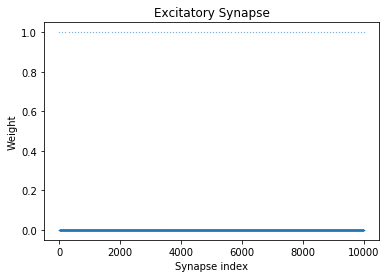

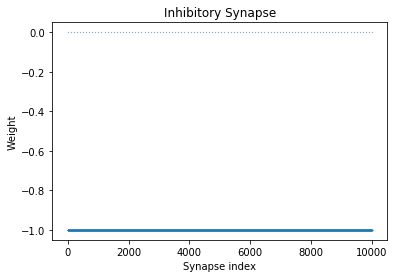

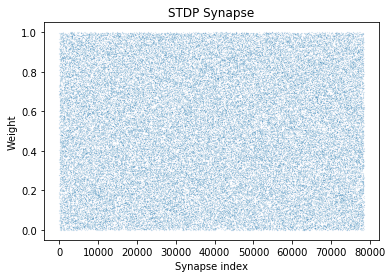

In [7]:
# 最初のSynapseのWeightを表示
b2.plot(connections['ei'].w,'.',markersize = 0.5)
b2.xlabel('Synapse index')
b2.ylabel('Weight')
b2.title("Excitatory Synapse");
b2.show()
b2.plot(connections['ie'].w,'.',markersize = 0.5)
b2.xlabel('Synapse index')
b2.ylabel('Weight')
b2.title("Inhibitory Synapse");
b2.show()
b2.plot(connections['Xe'].w,'.',markersize = 0.1)
b2.xlabel('Synapse index')
b2.ylabel('Weight')
b2.title("STDP Synapse");
b2.show()

In [8]:
# run the simulation（plotはSpikeファルダとSynapseフォルダに保存）
t_start = 0
b2.figure(figsize=(8.0, 6.0))
for j in range(num_examples):
    # signal input
    spike_rates = x_all[j,:] * input_intensity
    input_groups['X'].rates = spike_rates
    t_end = t_start + 500
    net.run(single_example_time)
    # rest input
    input_groups['X'].rates = 0 * b2.Hz
    net.run(resting_time)
    # plot
    b2.subplot(3,1,1)
    b2.plot(spike_monitors['X'].t/b2.ms, spike_monitors['X'].i, '.')
    b2.xlim([t_start, t_end])
    b2.ylabel("Input_layer")
    b2.title("Spike_%05d" % j)
    b2.subplot(3,1,2)
    b2.plot(spike_monitors['e'].t/b2.ms, spike_monitors['e'].i, '.')
    b2.xlim([t_start, t_end])
    b2.ylabel("Exc_layer")
    b2.subplot(3,1,3)
    b2.plot(spike_monitors['i'].t/b2.ms, spike_monitors['i'].i, '.')
    b2.xlim([t_start, t_end])
    b2.ylabel("Inh_layer")
    b2.savefig("Spike/raster_%05d.jpeg" % j)
    b2.clf()
    b2.plot(connections['Xe'].w,'.',markersize = 0.1)
    b2.xlabel('Synapse index')
    b2.ylabel('Weight')
    b2.title("Synapse_%05d" % j);
    b2.savefig("Synapse/weight_%05d.jpeg" % j)
    b2.clf()
    t_start = t_end
    print(j)

Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
0
Starting simulation at t=0.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
1
Starting simulation at t=1. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
2
Starting simulation at t=1.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
3
Starting simulation at t=2. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
4
Starting simulation at t=2.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
5
Starting simulation at t=3. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
6
Starting simulation at t=3.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
7
Starting simulation at t=4. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
8
Starting simulation at t=4.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
9
Starting simulation at t=5. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
10
Starting simula

89
Starting simulation at t=45. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
90
Starting simulation at t=45.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
91
Starting simulation at t=46. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
92
Starting simulation at t=46.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
93
Starting simulation at t=47. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
94
Starting simulation at t=47.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
95
Starting simulation at t=48. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
96
Starting simulation at t=48.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
97
Starting simulation at t=49. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
98
Starting simulation at t=49.5 s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
99


<Figure size 576x432 with 0 Axes>

In [9]:
STDP_Weight = connections['Xe'].w
np.save('training_weight.npy',STDP_Weight.get_item(range(STDP_Weight.shape[0])))

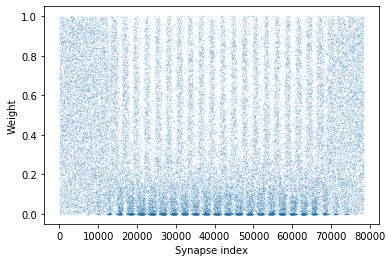

In [10]:
# 最終的なSynapseのWeight
b2.plot(connections['Xe'].w,'.',markersize = 0.1)
b2.xlabel('Synapse index')
b2.ylabel('Weight');
b2.show()

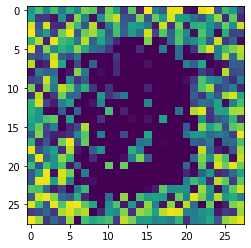

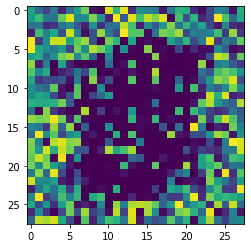

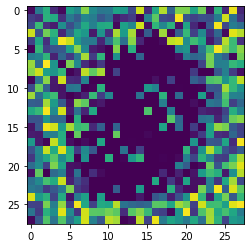

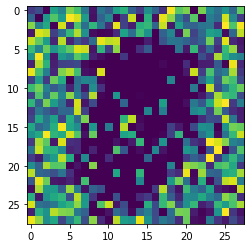

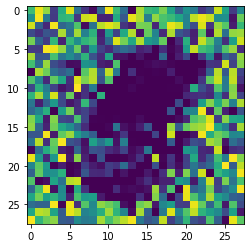

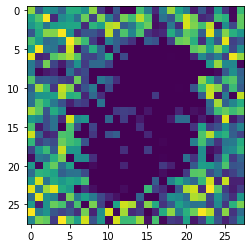

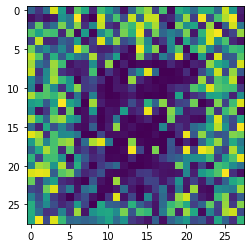

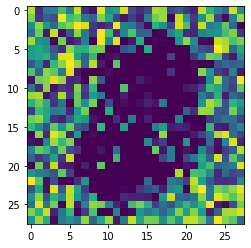

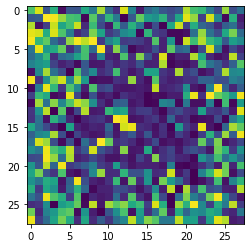

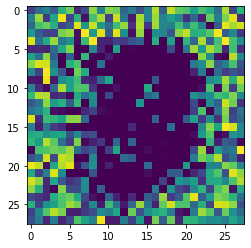

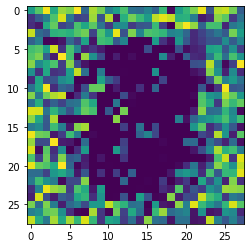

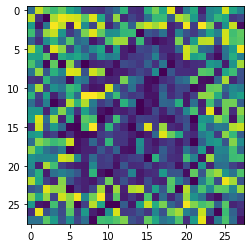

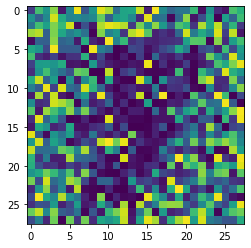

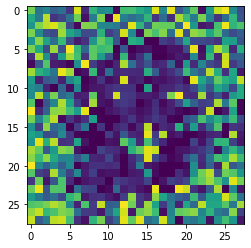

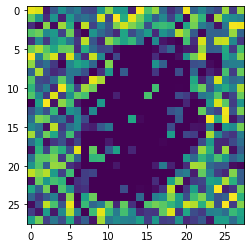

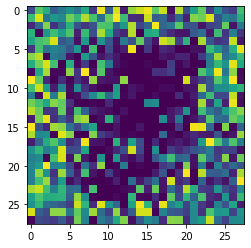

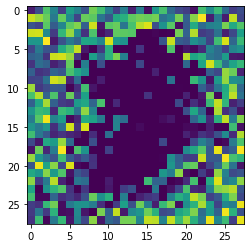

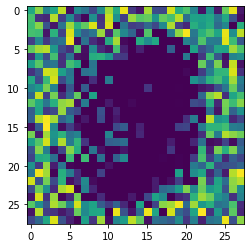

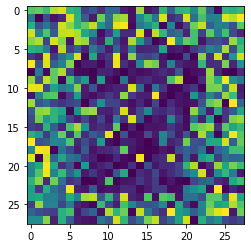

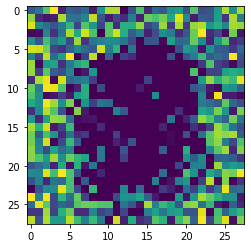

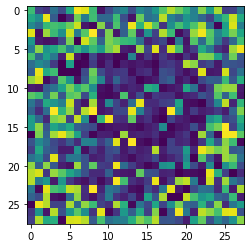

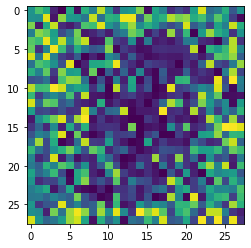

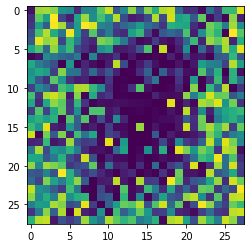

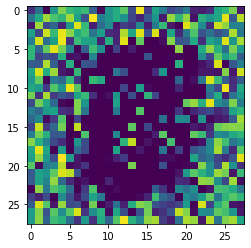

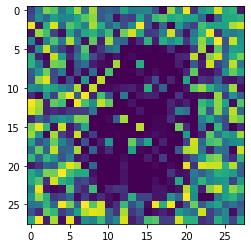

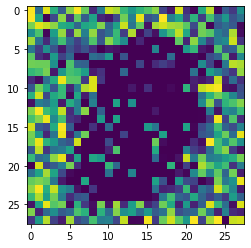

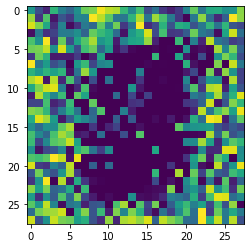

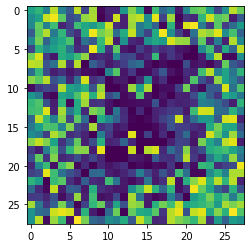

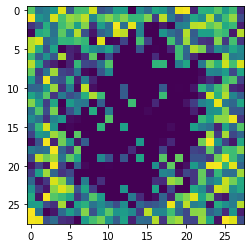

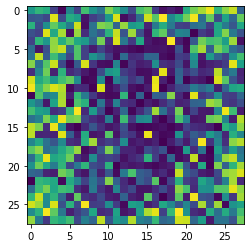

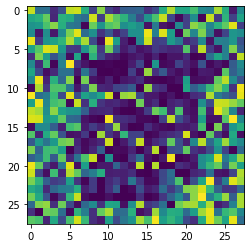

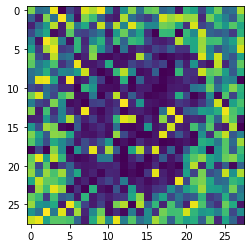

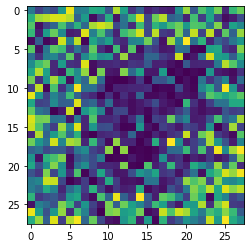

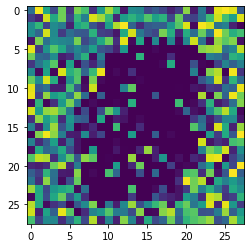

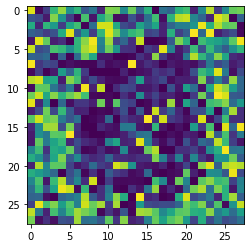

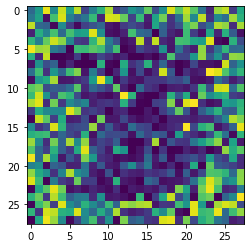

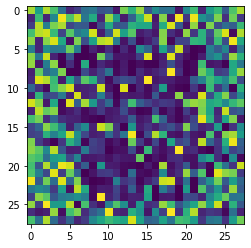

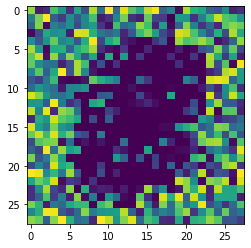

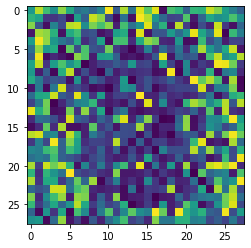

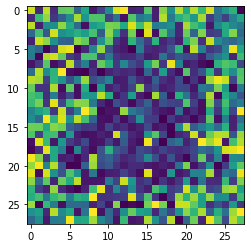

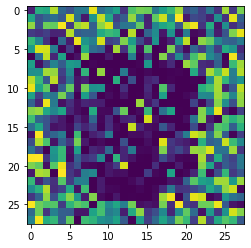

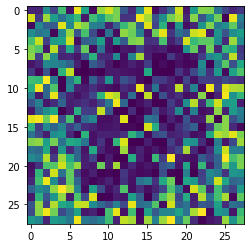

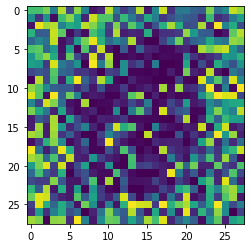

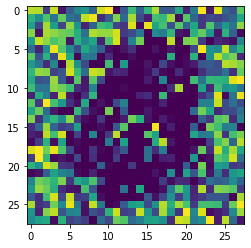

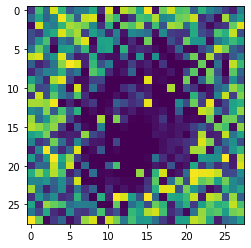

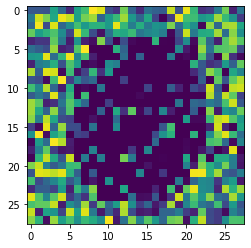

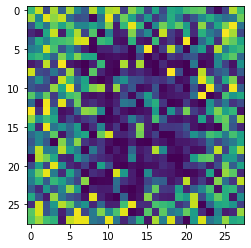

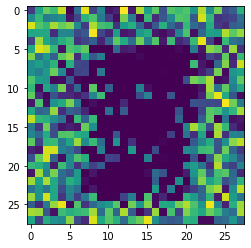

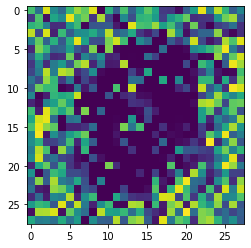

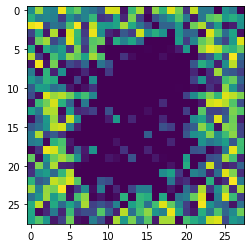

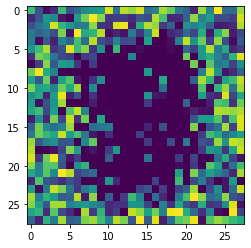

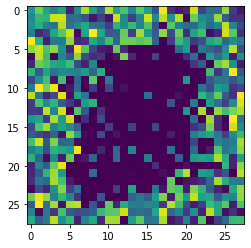

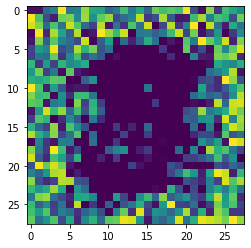

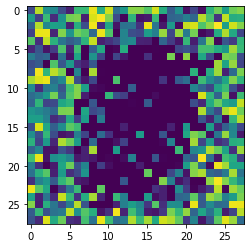

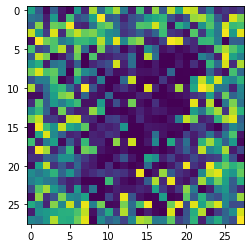

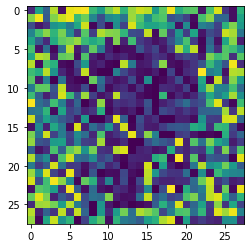

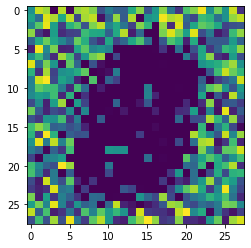

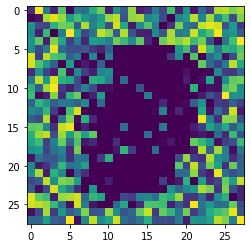

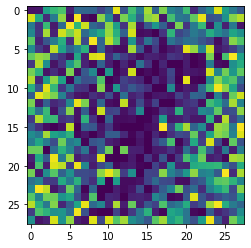

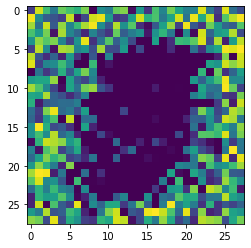

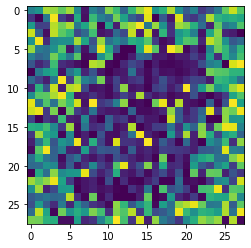

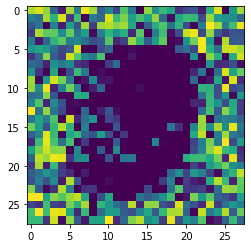

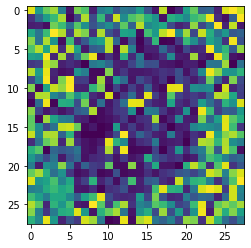

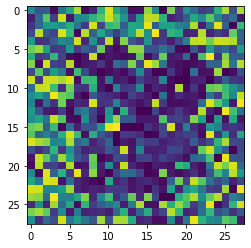

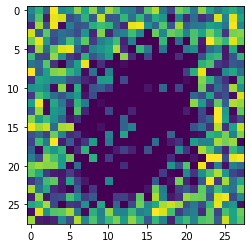

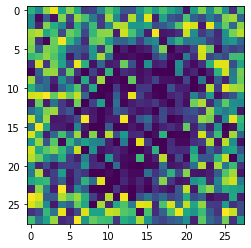

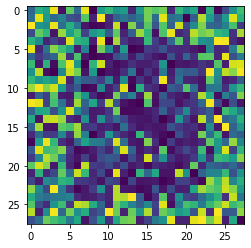

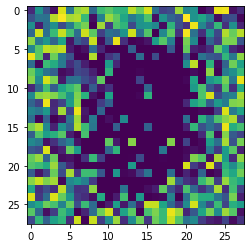

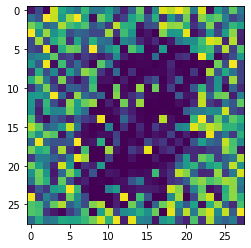

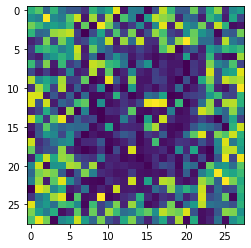

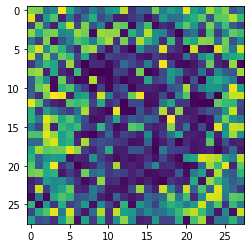

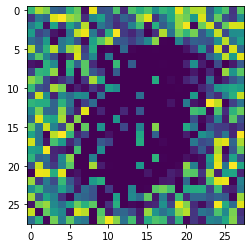

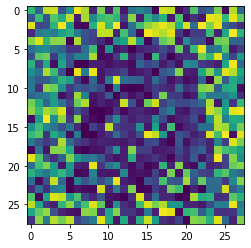

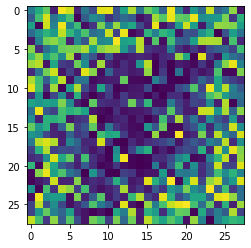

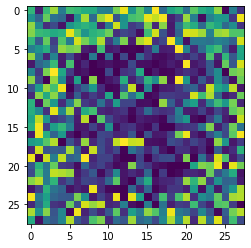

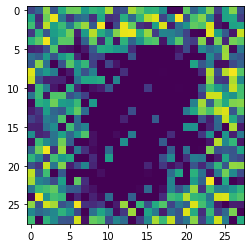

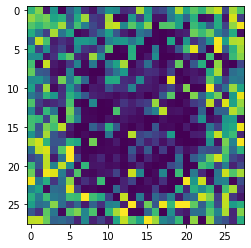

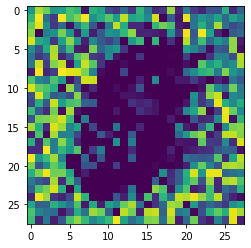

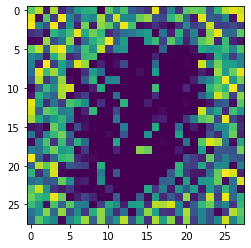

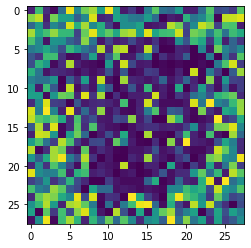

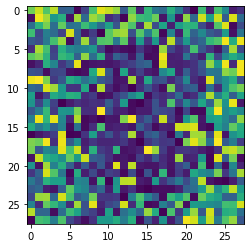

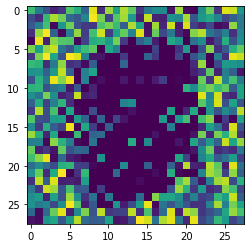

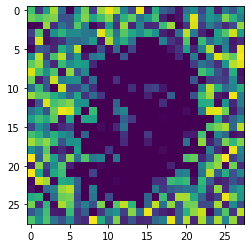

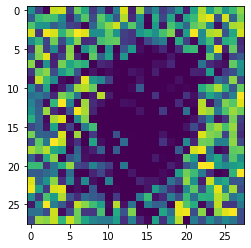

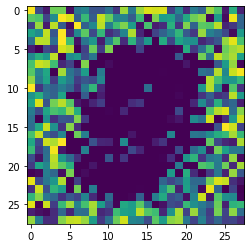

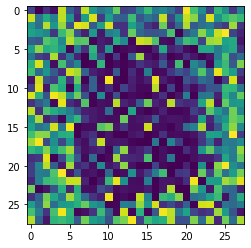

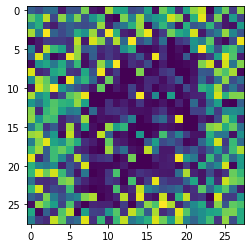

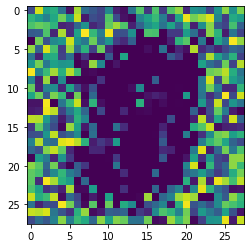

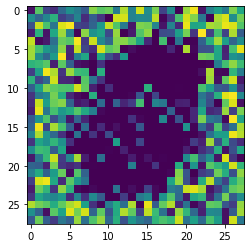

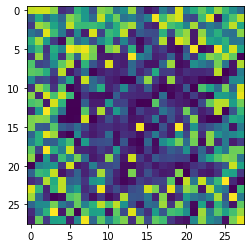

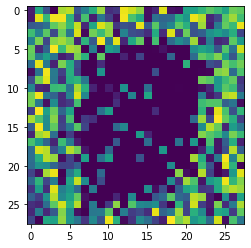

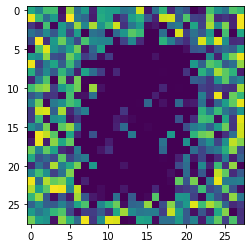

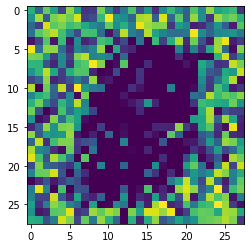

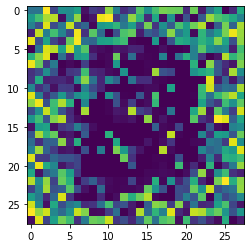

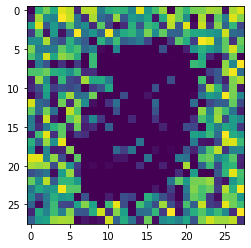

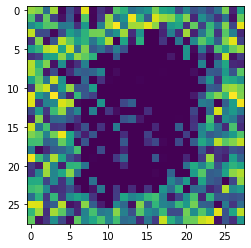

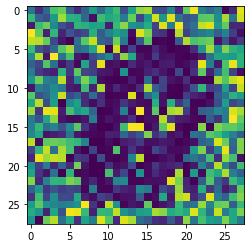

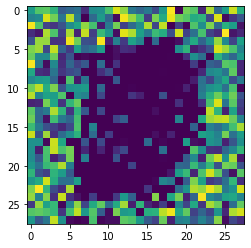

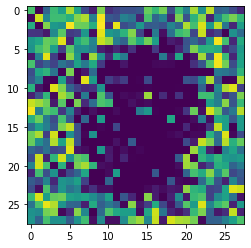

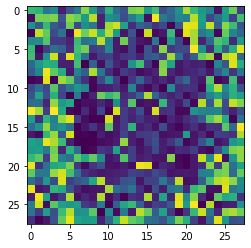

In [12]:
# Weight Mapの可視化
W = STDP_Weight.get_item(range(STDP_Weight.shape[0])).reshape([n_input, n_e])
for i in range(n_e):
    b2.imshow(W[:,i].reshape(28, 28))
    b2.show()

文字の大まかに輪郭は捉えることが出来た。
ただし、文字の部分のシナプス強度はむしろ減少している。